In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import time

import seaborn as sns

In [ ]:
pd.read_csv()

In [6]:
df_2023 = pd.DataFrame(data)
df_2023

,timestamp,freq,market,ba_name,load_MW
0,2022-01-01 23:45:00+00:00,5m,RT5M,CAISO,20192.67
1,2022-01-01 22:00:00+00:00,5m,RT5M,CAISO,17318.26
2,2022-01-01 22:10:00+00:00,5m,RT5M,CAISO,17454.12
3,2022-01-01 19:30:00+00:00,5m,RT5M,CAISO,17148.74
4,2022-01-01 19:35:00+00:00,5m,RT5M,CAISO,17047.47
...,...,...,...,...,...
104608,2022-12-31 13:40:00+00:00,5m,RT5M,CAISO,19404.24
104609,2022-12-31 12:15:00+00:00,5m,RT5M,CAISO,18772.96
104610,2022-12-31 12:30:00+00:00,5m,RT5M,CAISO,18797.62
104611,2022-12-31 10:55:00+00:00,5m,RT5M,CAISO,18811.79


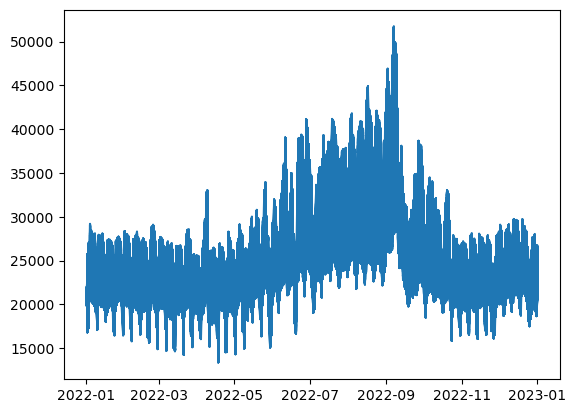

In [7]:
plt.plot(df_2023['timestamp'], df_2023['load_MW'])

/var/folders/r2/k7ydhtv97nvfmfl71y382zy40000gn/T/ipykernel_87663/1918889514.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_2023['viz'] = df_2023['timestamp'].dt.time.astype(str).astype('datetime64[ns]')


NameError: name 'df_2016' is not defined

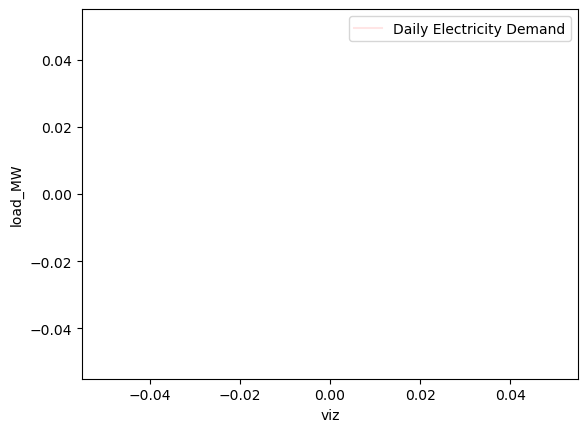

In [8]:
# Create new column of datetimes so axes between different plots are consistent (and so matplotlib can actually read these)
# Will return time-zone naive times, so for loop doesn't need to worry about them
df_2023['viz'] = df_2023['timestamp'].dt.time.astype(str).astype('datetime64[ns]') 
curr_day = np.datetime64("2015-01-01")
next_day = np.datetime64('2015-01-02')

# Overlays every day's duck curve on top of one another
labeled = 0
while next_day <= np.datetime64('2016-01-01'):
    if curr_day != '2015-04-03':
        curr_day_df = df_2023[(df_2023['timestamp'] < str(next_day)) & (df_2023['timestamp'] >= str(curr_day))]
        if not labeled:
            sns.lineplot(x='viz', y='load_MW', data=curr_day_df, c='r', alpha=0.1, label='Daily Electricity Demand')
            labeled += 1
        else:
            sns.lineplot(x='viz', y='load_MW', data=curr_day_df, c='r', alpha=0.1)
    curr_day += np.timedelta64(1, 'D')
    next_day += np.timedelta64(1, 'D')

# Compute average duck
avg_compute = df_2016
avg_compute['time'] = avg_compute['viz'].dt.time
avg_compute = avg_compute.groupby('time')['load_MW'].mean()
avg_compute = avg_compute.reset_index()
avg_compute['time'] = avg_compute['time'].astype(str).astype('datetime64[ns]')
sns.lineplot(x='time', y='load_MW', data=avg_compute, c='black', label='Average Demand')

plt.legend()
plt.xticks(rotation=20)
plt.title('Plotting the Duck Curve')
plt.xlabel('')